In [1]:
!pip install torch torchvision transformers

In [2]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class KidneyDataset(Dataset):
    def __init__(self, root_dir, feature_extractor):
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
        self.data = []
        for idx, cls in enumerate(self.classes):
            path = os.path.join(root_dir, cls)
            for img in os.listdir(path):
                self.data.append((os.path.join(path, img), idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = torchvision.io.read_image(img_path)
        image = self.feature_extractor(images=image, return_tensors="pt").pixel_values[0]
        return image, label

root_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
dataset = KidneyDataset(root_dir, feature_extractor)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit.classifier = nn.Linear(self.vit.classifier.in_features, num_classes)

    def forward(self, x):
        x = self.vit(pixel_values=x).logits
        return x

model = ViTClassifier(num_classes=4)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTClassifier(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (int

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses = []
train_accuracies = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Accuracy: {epoch_acc}')


Epoch 1, Loss: 0.9504728078460082, Accuracy: 0.6484531940538368
Epoch 2, Loss: 0.762158582607905, Accuracy: 0.7250903977501004
Epoch 3, Loss: 0.6949366258027462, Accuracy: 0.7511048613901166
Epoch 4, Loss: 0.6438919609555831, Accuracy: 0.7690839694656488
Epoch 5, Loss: 0.5526164309241068, Accuracy: 0.8085576536761752
Epoch 6, Loss: 0.5354291405051183, Accuracy: 0.8173965447971073
Epoch 7, Loss: 0.5447848459275869, Accuracy: 0.810365608678184
Epoch 8, Loss: 0.5038234928193001, Accuracy: 0.8279429489754921
Epoch 9, Loss: 0.40807403437793255, Accuracy: 0.8560666934511852
Epoch 10, Loss: 0.4951630940135473, Accuracy: 0.8223182000803535
Epoch 11, Loss: 0.39511858738767797, Accuracy: 0.8605865809562073
Epoch 12, Loss: 0.4470039047539616, Accuracy: 0.8415026114905585
Epoch 13, Loss: 0.436534224006419, Accuracy: 0.844817195660908
Epoch 14, Loss: 0.30372239088711256, Accuracy: 0.8931297709923665
Epoch 15, Loss: 0.3343440346682492, Accuracy: 0.8817798312575331
Epoch 16, Loss: 0.24908660042386216

In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")
print(classification_report(all_labels, all_preds, target_names=['Cyst', 'Normal', 'Stone', 'Tumor']))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)


In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [ ]:
df = pd.DataFrame({
    'Model': ['ViTClassifier'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})
df.to_csv('model_performance.csv', index=False)


In [ ]:
np.savetxt("confusion_matrix.csv", conf_matrix, delimiter=",", fmt='%d')


In [10]:
torch.save(model.state_dict(), 'vit_kidney_disease_classifier.pth')

In [11]:
import seaborn as sns

# Assuming `conf_matrix` is your confusion matrix obtained from the evaluation step
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cyst', 'Normal', 'Stone', 'Tumor'], yticklabels=['Cyst', 'Normal', 'Stone', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


NameError: name 'conf_matrix' is not defined

<Figure size 1000x700 with 0 Axes>

In [1]:
model_path = '/kaggle/working/vit_kidney_disease_classifier.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


ViTClassifier(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (int

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy and other metrics if needed
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=['Cyst', 'Normal', 'Stone', 'Tumor']))


Accuracy: 0.9642570281124498
              precision    recall  f1-score   support

        Cyst       0.92      0.99      0.96       699
      Normal       0.99      0.98      0.99      1017
       Stone       0.96      0.86      0.91       299
       Tumor       0.98      0.94      0.96       475

    accuracy                           0.96      2490
   macro avg       0.96      0.95      0.95      2490
weighted avg       0.97      0.96      0.96      2490



Accuracy: 0.9642570281124498
Precision: 0.9629882646841794
Recall: 0.9457871315972106
F1 Score: 0.9533255041792632


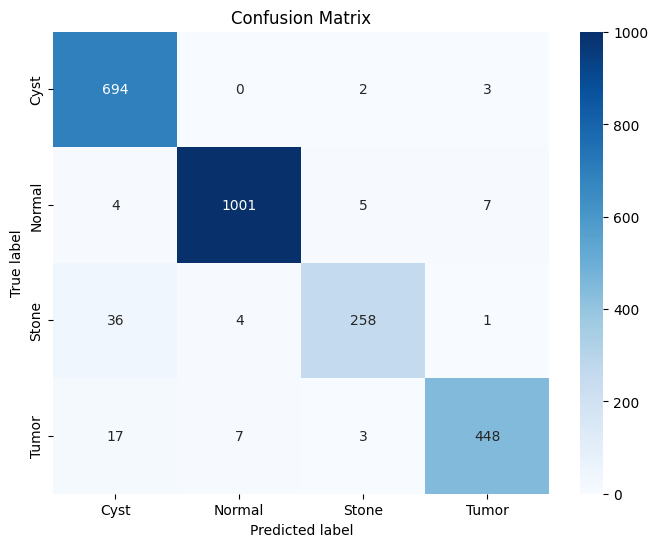

In [3]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate classification metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

# Print metrics to console
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}')

# Create a DataFrame and save it to a CSV file
report_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})
report_df.to_csv('/kaggle/working/classification_report.csv', index=False)

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cyst', 'Normal', 'Stone', 'Tumor'], yticklabels=['Cyst', 'Normal', 'Stone', 'Tumor'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()


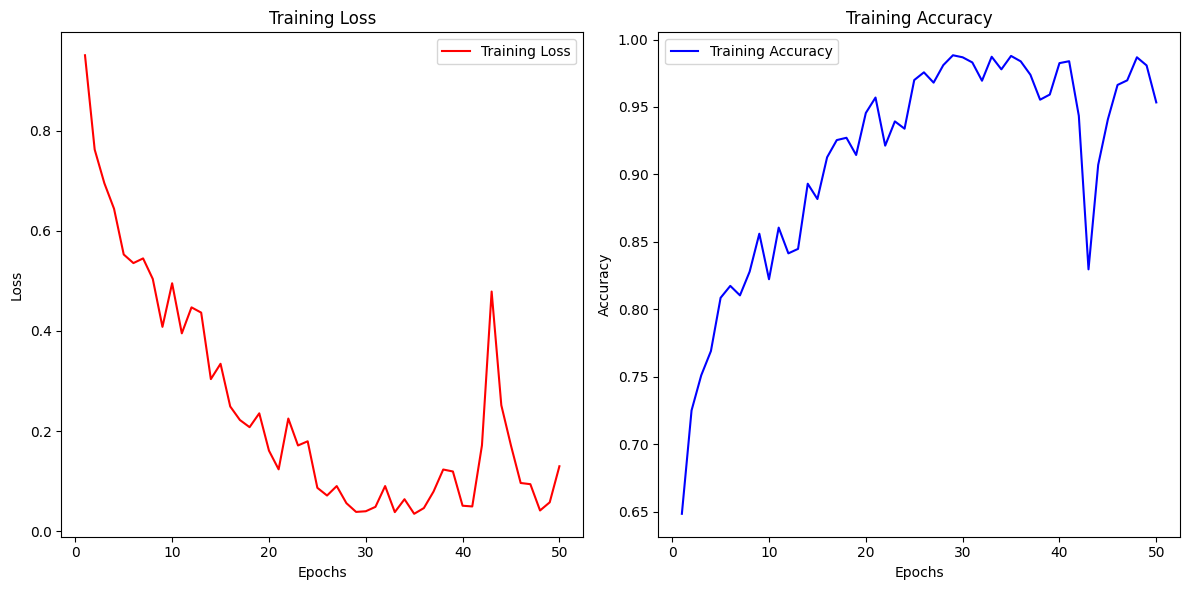

In [5]:
import matplotlib.pyplot as plt

# Assuming train_losses and train_accuracies contain loss and accuracy for each epoch
epochs = range(1, num_epochs + 1)

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_loss_accuracy.png')
plt.show()
